<a href="https://colab.research.google.com/github/ASHIKAMOHAN/GalaxyProject/blob/main/GalaxyDistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [57]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Function to load datasets
def load_data():
    happy_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/happy_D.txt'
    ]
    teddy_files = [
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_A.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/teddy_D.txt'
    ]

    happy_dfs = [pd.read_csv(file, delimiter='\t') for file in happy_files]
    teddy_dfs = [pd.read_csv(file, delimiter='\t', skiprows=6) for file in teddy_files]

    return happy_dfs, teddy_dfs




In [59]:
# Load datasets
happy_dfs, teddy_dfs = load_data()

# Define the correct column names
column_names = ['id', 'mag_r', 'u-g', 'g-r', 'r-i', 'i-z', 'z_spec', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5']

In [61]:
# Clean and rename columns
def clean_and_rename_columns(dfs, column_names):
    cleaned_dfs = []
    for df in dfs:
        if df.shape[1] == 1:
            df = df.iloc[:, 0].str.split(expand=True)
        df.columns = column_names
        cleaned_dfs.append(df)
    return cleaned_dfs

# Apply the function to all datasets
happy_dfs = clean_and_rename_columns(happy_dfs, column_names)
teddy_dfs = clean_and_rename_columns(teddy_dfs, column_names)



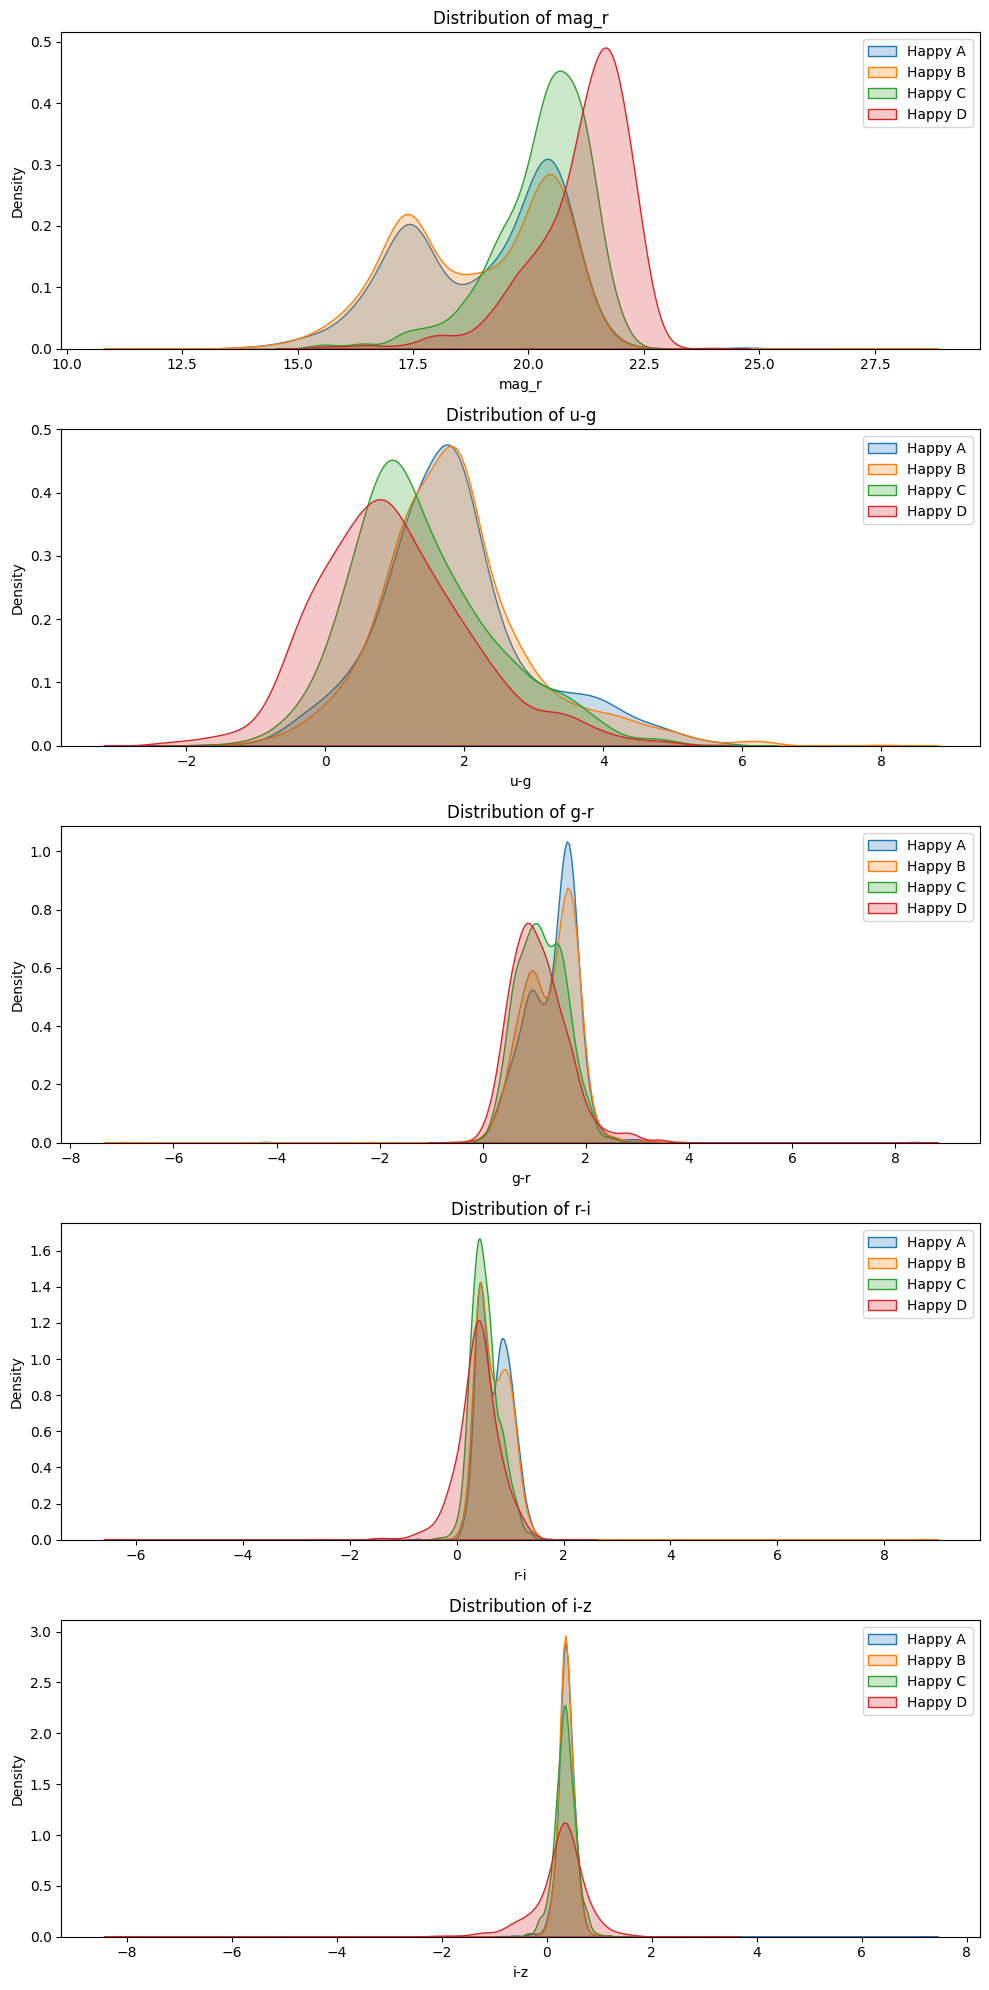

In [109]:
# Convert columns to numeric
def convert_to_numeric(dfs):
    for df in dfs:
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return dfs

# Convert the dataframes to numeric
happy_dfs = convert_to_numeric(happy_dfs)
teddy_dfs = convert_to_numeric(teddy_dfs)

# Function to sample data for faster plotting
def sample_data(dfs, sample_size=1000):
    sampled_dfs = [df.sample(n=min(sample_size, len(df)), random_state=42) for df in dfs]
    return sampled_dfs

# Sample the data
happy_dfs_sampled = sample_data(happy_dfs)
teddy_dfs_sampled = sample_data(teddy_dfs)

# Function to plot histograms and KDE
def plot_histograms_and_kde(dfs, labels, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 20))
    for col, ax in zip(columns, axes):
        for df, label in zip(dfs, labels):
            sns.kdeplot(df[col], fill=True, label=label, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Plot distributions for Happy datasets
columns_to_plot = ['mag_r', 'u-g', 'g-r', 'r-i', 'i-z']
happy_labels = ['Happy A', 'Happy B', 'Happy C', 'Happy D']

plot_histograms_and_kde(happy_dfs_sampled, happy_labels, columns_to_plot)

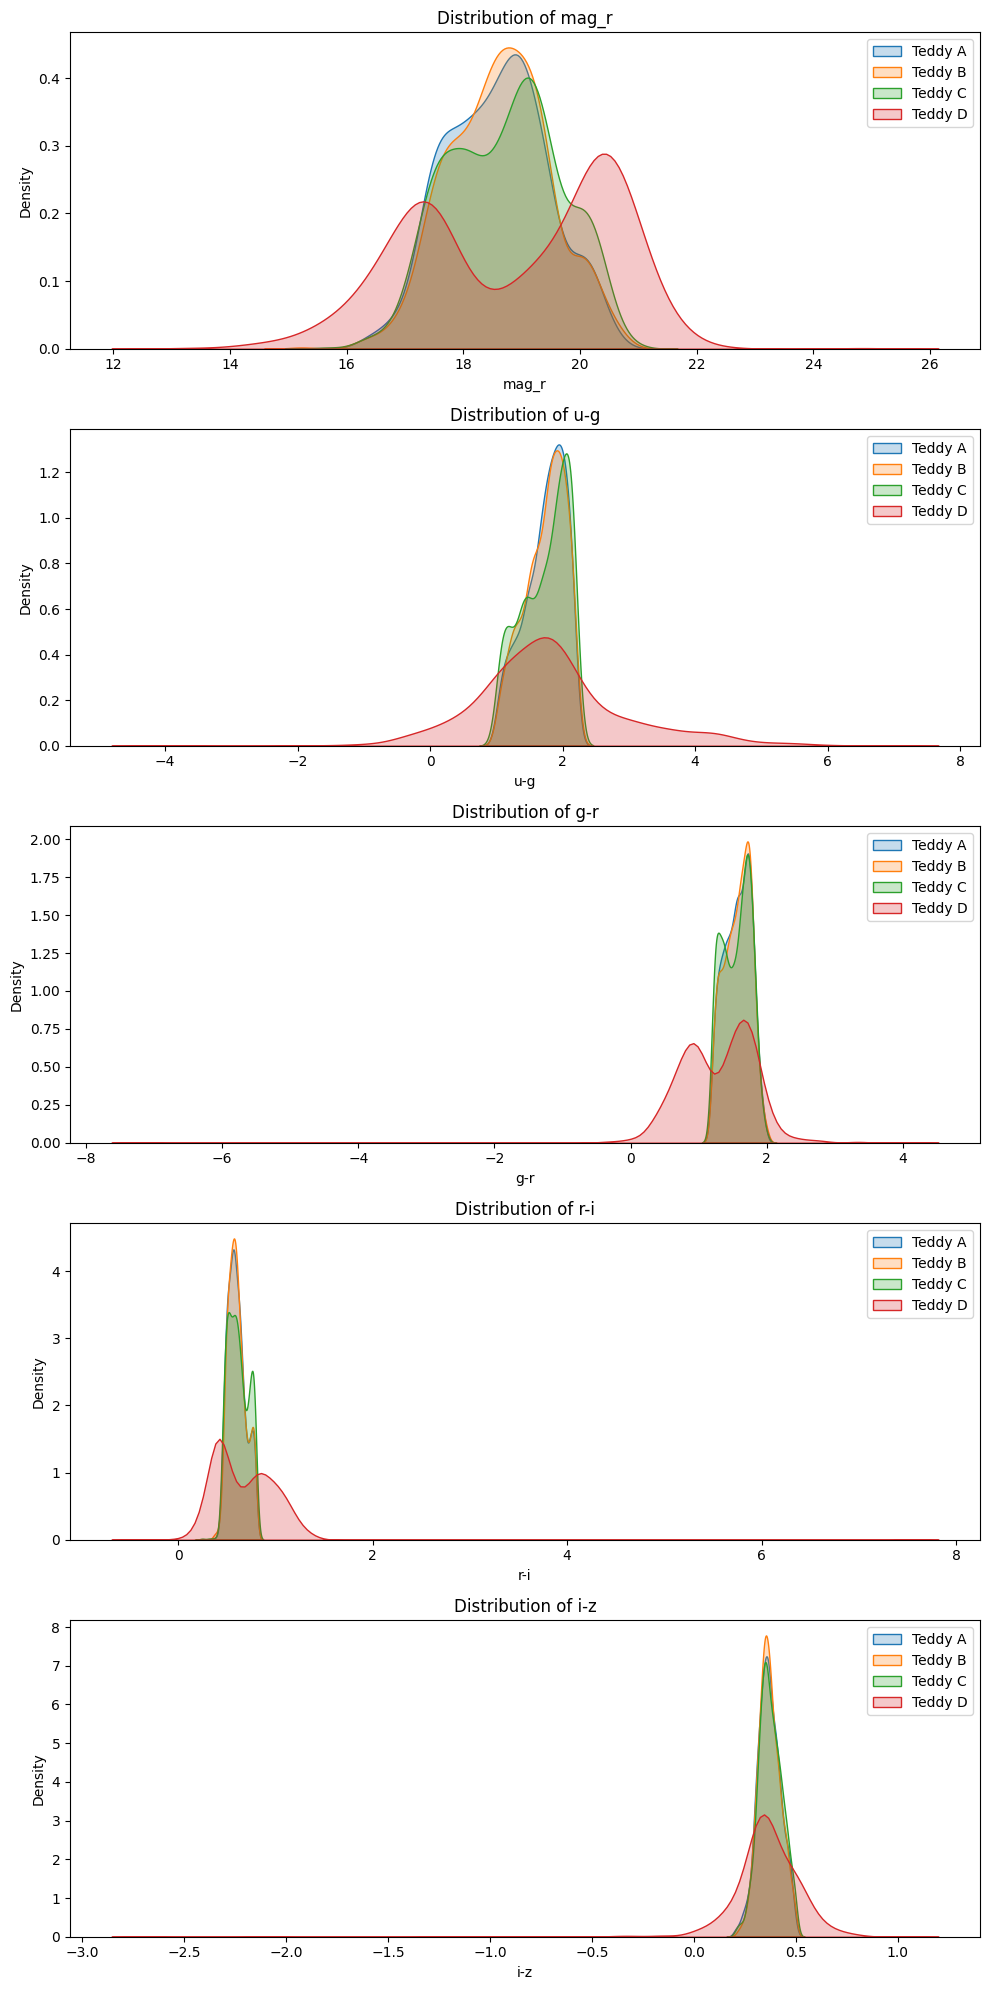

In [8]:
# Plot distributions for Teddy datasets
teddy_labels = ['Teddy A', 'Teddy B', 'Teddy C', 'Teddy D']

plot_histograms_and_kde(teddy_dfs_sampled, teddy_labels, columns_to_plot)

In [75]:
# Preprocess the datasets
def preprocess_datasets(dfs):
    X_train, y_train = preprocess_data(dfs[0])  # Set A for Training
    X_val, y_val = preprocess_data(dfs[1])      # Set B for Validation
    X_test_b, y_test_b = preprocess_data(dfs[1]) # Set B for Testing
    X_test_c, y_test_c = preprocess_data(dfs[2]) # Set C for Testing
    X_test_d, y_test_d = preprocess_data(dfs[3]) # Set D for Testing
    return X_train, y_train, X_val, y_val, X_test_b, y_test_b, X_test_c, y_test_c, X_test_d, y_test_d

# Happy datasets
X_train_happy, y_train_happy, X_val_happy, y_val_happy, X_test_happy_b, y_test_happy_b, X_test_happy_c, y_test_happy_c, X_test_happy_d, y_test_happy_d = preprocess_datasets(happy_dfs)

# Teddy datasets
X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, X_test_teddy_b, y_test_teddy_b, X_test_teddy_c, y_test_teddy_c, X_test_teddy_d, y_test_teddy_d = preprocess_datasets(teddy_dfs)

def handle_nan(df):
    if df.isnull().values.any():
        df = df.fillna(df.mean())
    return df

# Apply NaN handling to datasets
X_train_happy = handle_nan(X_train_happy)
X_val_happy = handle_nan(X_val_happy)
X_test_happy_b = handle_nan(X_test_happy_b)
X_test_happy_c = handle_nan(X_test_happy_c)
X_test_happy_d = handle_nan(X_test_happy_d)
y_train_happy = handle_nan(y_train_happy)
y_val_happy = handle_nan(y_val_happy)
y_test_happy_b = handle_nan(y_test_happy_b)
y_test_happy_c = handle_nan(y_test_happy_c)
y_test_happy_d = handle_nan(y_test_happy_d)

X_train_teddy = handle_nan(X_train_teddy)
X_val_teddy = handle_nan(X_val_teddy)
X_test_teddy_b = handle_nan(X_test_teddy_b)
X_test_teddy_c = handle_nan(X_test_teddy_c)
X_test_teddy_d = handle_nan(X_test_teddy_d)
y_train_teddy = handle_nan(y_train_teddy)
y_val_teddy = handle_nan(y_val_teddy)
y_test_teddy_b = handle_nan(y_test_teddy_b)
y_test_teddy_c = handle_nan(y_test_teddy_c)
y_test_teddy_d = handle_nan(y_test_teddy_d)

# Verify no NaN values are present
def verify_no_nan(df, name):
    if df.isnull().values.any():
        print(f"NaN values found in {name}")
    else:
        print(f"No NaN values in {name}")

# Verify all datasets
verify_no_nan(X_train_happy, 'X_train_happy')
verify_no_nan(X_val_happy, 'X_val_happy')
verify_no_nan(X_test_happy_b, 'X_test_happy_b')
verify_no_nan(X_test_happy_c, 'X_test_happy_c')
verify_no_nan(X_test_happy_d, 'X_test_happy_d')
verify_no_nan(y_train_happy, 'y_train_happy')
verify_no_nan(y_val_happy, 'y_val_happy')
verify_no_nan(y_test_happy_b, 'y_test_happy_b')
verify_no_nan(y_test_happy_c, 'y_test_happy_c')
verify_no_nan(y_test_happy_d, 'y_test_happy_d')

verify_no_nan(X_train_teddy, 'X_train_teddy')
verify_no_nan(X_val_teddy, 'X_val_teddy')
verify_no_nan(X_test_teddy_b, 'X_test_teddy_b')
verify_no_nan(X_test_teddy_c, 'X_test_teddy_c')
verify_no_nan(X_test_teddy_d, 'X_test_teddy_d')
verify_no_nan(y_train_teddy, 'y_train_teddy')
verify_no_nan(y_val_teddy, 'y_val_teddy')
verify_no_nan(y_test_teddy_b, 'y_test_teddy_b')
verify_no_nan(y_test_teddy_c, 'y_test_teddy_c')
verify_no_nan(y_test_teddy_d, 'y_test_teddy_d')

In [83]:
# Load weights
def load_weights():
    weight_files = [
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Happy/weights_for_D.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_B.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_C.txt',
        '/content/drive/MyDrive/GalaxyProject/Teddy/weights_for_D.txt'
    ]
    weights = [pd.read_csv(file, delimiter='\t', header=None).values.flatten() for file in weight_files]
    return weights

weights = load_weights()



In [84]:
# Adjust weights lengths to match validation and test sets
def adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d, X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d):
    len_val_happy = len(X_val_happy)
    len_test_happy_b = len(X_test_happy_b)
    len_test_happy_c = len(X_test_happy_c)
    len_test_happy_d = len(X_test_happy_d)
    len_val_teddy = len(X_val_teddy)
    len_test_teddy_b = len(X_test_teddy_b)
    len_test_teddy_c = len(X_test_teddy_c)
    len_test_teddy_d = len(X_test_teddy_d)

    weights_val_happy = weights[0][:len_val_happy]
    weights_test_happy_b = weights[0][:len_test_happy_b]
    weights_test_happy_c = weights[1][:len_test_happy_c]
    weights_test_happy_d = weights[2][:len_test_happy_d]
    weights_val_teddy = weights[3][:len_val_teddy]
    weights_test_teddy_b= weights[3][:len_test_teddy_b]
    weights_test_teddy_c = weights[4][:len_test_teddy_c]
    weights_test_teddy_d = weights[5][:len_test_teddy_d]

        # Adjust weights to match lengths if needed
    if len(weights_val_happy) < len_val_happy:
        weights_val_happy = np.concatenate([weights_val_happy, np.ones(len_val_happy - len(weights_val_happy))])
    if len(weights_test_happy_b) < len_test_happy_b:
        weights_test_happy_b = np.concatenate([weights_test_happy_b, np.ones(len_test_happy_b - len(weights_test_happy_b))])
    if len(weights_test_happy_c) < len_test_happy_c:
        weights_test_happy_c = np.concatenate([weights_test_happy_c, np.ones(len_test_happy_c - len(weights_test_happy_c))])
    if len(weights_test_happy_d) < len_test_happy_d:
        weights_test_happy_d = np.concatenate([weights_test_happy_d, np.ones(len_test_happy_d - len(weights_test_happy_d))])

    if len(weights_val_teddy) < len_val_teddy:
        weights_val_teddy = np.concatenate([weights_val_teddy, np.ones(len_val_teddy - len(weights_val_teddy))])
    if len(weights_test_teddy_b) < len_test_teddy_b:
        weights_test_teddy_b = np.concatenate([weights_test_teddy_b, np.ones(len_test_teddy_b - len(weights_test_teddy_b))])
    if len(weights_test_teddy_c) < len_test_teddy_c:
        weights_test_teddy_c = np.concatenate([weights_test_teddy_c, np.ones(len_test_teddy_c - len(weights_test_teddy_c))])
    if len(weights_test_teddy_d) < len_test_teddy_d:
        weights_test_teddy_d = np.concatenate([weights_test_teddy_d, np.ones(len_test_teddy_d - len(weights_test_teddy_d))])

    return weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c,
    weights_test_teddy_d,weights_val_happy, weights_test_happy_b, weights_test_happy_c, weights_test_happy_d, weights_val_teddy, weights_test_teddy_b, weights_test_teddy_c,
    weights_test_teddy_d = adjust_weights(weights, X_val_happy, X_test_happy_b, X_test_happy_c, X_test_happy_d, X_val_teddy, X_test_teddy_b, X_test_teddy_c, X_test_teddy_d)

Length of X_train_happy: 74950
Length of y_train_happy: 74950
Length of X_val_happy: 74900
Length of y_val_happy: 74900
Length of weights_val_happy: 74900
Length of X_test_happy_c: 60315
Length of y_test_happy_c: 60315
Length of weights_test_happy_c: 60315
Length of X_test_happy_d: 74642
Length of y_test_happy_d: 74642
Length of weights_test_happy_d: 74642
Length of X_train_teddy: 74309
Length of y_train_teddy: 74309
Length of X_val_teddy: 74557
Length of y_val_teddy: 74557
Length of weights_val_teddy: 74557
Length of X_test_teddy_c: 97980
Length of y_test_teddy_c: 97980
Length of weights_test_teddy_c: 97980
Length of X_test_teddy_d: 75924
Length of y_test_teddy_d: 75924
Length of weights_test_teddy_d: 75924


In [ ]:
print(“Length of X_train_happy:”, len(X_train_happy))
print(“Length of y_train_happy:”, len(y_train_happy))
print(“Length of X_val_happy:”, len(X_val_happy))
print(“Length of y_val_happy:”, len(y_val_happy))
print(“Length of weights_val_happy:”, len(weights_val_happy))
print(“Length of X_test_happy_b:”, len(X_test_happy_b))
print(“Length of y_test_happy_b:”, len(y_test_happy_b))
print(“Length of weights_test_happy_b:”, len(weights_test_happy_b))
print(“Length of X_test_happy_c:”, len(X_test_happy_c))
print(“Length of y_test_happy_c:”, len(y_test_happy_c))
print(“Length of weights_test_happy_c:”, len(weights_test_happy_c))
print(“Length of X_test_happy_d:”, len(X_test_happy_d))
print(“Length of y_test_happy_d:”, len(y_test_happy_d))
print(“Length of weights_test_happy_d:”, len(weights_test_happy_d))

print(“Length of X_train_teddy:”, len(X_train_teddy))
print(“Length of y_train_teddy:”, len(y_train_teddy))
print(“Length of X_val_teddy:”, len(X_val_teddy))
print(“Length of y_val_teddy:”, len(y_val_teddy))
print(“Length of weights_val_teddy:”, len(weights_val_teddy))
print(“Length of X_test_teddy_b:”, len(X_test_teddy_b))
print(“Length of y_test_teddy_b:”, len(y_test_teddy_b))
print(“Length of weights_test_teddy_b:”, len(weights_test_teddy_b))
print(“Length of X_test_teddy_c:”, len(X_test_teddy_c))
print(“Length of y_test_teddy_c:”, len(y_test_teddy_c))
print(“Length of weights_test_teddy_c:”, len(weights_test_teddy_c))
print(“Length of X_test_teddy_d:”, len(X_test_teddy_d))
print(“Length of y_test_teddy_d:”, len(y_test_teddy_d))
print(“Length of weights_test_teddy_d:”, len(weights_test_teddy_d))

In [90]:
# Model training functions

# Random Forest
def train_random_forest(X_train, y_train, X_val, y_val, weights_train, weights_val):
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_rf = rf.predict(X_val)
  rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False, sample_weight=weights_val)
  r2_rf = r2_score(y_val, y_pred_rf)
  mae_rf = mean_absolute_error(y_val, y_pred_rf)
  medae_rf = median_absolute_error(y_val, y_pred_rf)
  return y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf





In [91]:
def train_gradient_boost(X_train, y_train, X_val, y_val, weights_train, weights_val):
  gb = GradientBoostingRegressor()
  gb.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_gb = gb.predict(X_val)
  rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False, sample_weight=weights_val)
  r2_gb = r2_score(y_val, y_pred_gb)
  mae_gb = mean_absolute_error(y_val, y_pred_gb)
  medae_gb = median_absolute_error(y_val, y_pred_gb)
  return y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb

In [88]:
def train_decision_tree(X_train, y_train, X_val, y_val, weights_train=None, weights_val=None):
  dt = DecisionTreeRegressor()
  dt.fit(X_train, y_train)
  y_pred_dt = dt.predict(X_val)
  rmse_dt = mean_squared_error(y_val, y_pred_dt, squared=False)
  r2_dt = r2_score(y_val, y_pred_dt)
  mae_dt = mean_absolute_error(y_val, y_pred_dt)
  medae_dt = median_absolute_error(y_val, y_pred_dt)
  return y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt

In [89]:
def train_xgboost(X_train, y_train, X_val, y_val, weights_train, weights_val):
  xgb = XGBRegressor()
  xgb.fit(X_train, y_train, sample_weight=weights_train)
  y_pred_xgb = xgb.predict(X_val)
  rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False, sample_weight=weights_val)
  r2_xgb = r2_score(y_val, y_pred_xgb)
  mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
  medae_xgb = median_absolute_error(y_val, y_pred_xgb)
  return y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb

In [92]:
# Standardize the data
scaler = StandardScaler()
X_train_happy_scaled = scaler.fit_transform(X_train_happy)
X_val_happy_scaled = scaler.transform(X_val_happy)
X_test_happy_b_scaled = scaler.transform(X_test_happy_b)
X_test_happy_c_scaled = scaler.transform(X_test_happy_c)
X_test_happy_d_scaled = scaler.transform(X_test_happy_d)

X_train_teddy_scaled = scaler.fit_transform(X_train_teddy)
X_val_teddy_scaled = scaler.transform(X_val_teddy)
X_test_teddy_b_scaled = scaler.transform(X_test_teddy_b)
X_test_teddy_c_scaled = scaler.transform(X_test_teddy_c)
X_test_teddy_d_scaled = scaler.transform(X_test_teddy_d)

class SVRScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        n = len(y)

        for epoch in range(self.epochs):
            for i in range(n):
                if y[i] * (np.dot(X[i], self.w) + self.b) < 1:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(X[i], y[i]))
                    self.b -= self.learning_rate * y[i]
                else:
                    self.w -= self.learning_rate * 2 * self.lambda_param * self.w

    def predict(self, X):
        return np.dot(X, self.w) + self.b



In [93]:
class KNNScratch:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_val):
        y_pred = np.zeros(X_val.shape[0])
        for i, x in enumerate(X_val):
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_indices = np.argsort(distances)[:self.k]
            y_pred[i] = np.mean(self.y_train[k_indices])
        return y_pred

In [94]:
# Ensure weights_train is consistent
weights_train_happy = np.ones(len(X_train_happy))
weights_train_teddy = np.ones(len(X_train_teddy))

In [95]:
print('Training and evaluating models on Happy dataset…')

Training and evaluating models on Happy dataset…


In [96]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_happy, y_train_happy, X_val_happy, y_val_happy, weights_train_happy, weights_val_happy)
print(f'Random Forest (Happy - Set B) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_happy, y_train_happy, X_val_happy, y_val_happy, weights_train_happy, weights_val_happy)
print(f'Gradient Boost (Happy - Set B) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_happy, y_train_happy, X_val_happy, y_val_happy)
print(f'Decision Tree (Happy - Set B) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_happy, y_train_happy, X_val_happy, y_val_happy, weights_train_happy, weights_val_happy)
print(f'XGBoost (Happy - Set B) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')


Random Forest (Happy - Set B) RMSE: 0.054641203196928244, R2: 0.9332815108105861, MAE: 0.030927285250867825, MedAE: 0.01861616500000001
Gradient Boost (Happy - Set B) RMSE: 0.05627515705271315, R2: 0.9293217697158068, MAE: 0.033384319206908916, MedAE: 0.021306120608172552
Decision Tree (Happy - Set B) RMSE: 0.0756736614694996, R2: 0.8717751320415866, MAE: 0.04345353834445929, MedAE: 0.025924999999999976
XGBoost (Happy - Set B) RMSE: 0.055347417961839576, R2: 0.9316418718534801, MAE: 0.03127249861054746, MedAE: 0.01890806471252443


In [97]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_happy, y_train_happy, X_test_happy, y_test_happy, weights_train_happy, weights_test_happy)
print(f'Random Forest (Happy - Set C) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy, y_test_happy, weights_train_happy, weights_test_happy)
print(f'Gradient Boost (Happy - Set C) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_happy, y_train_happy, X_test_happy, y_test_happy)
print(f'Decision Tree (Happy - Set C) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_happy, y_train_happy, X_test_happy, y_test_happy, weights_train_happy, weights_test_happy)
print(f'XGBoost (Happy - Set C) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')

Random Forest (Happy - Set C) RMSE: 0.11814383666022962, R2: 0.6262774098811361, MAE: 0.07342156924081904, MedAE: 0.04906705999999994
Gradient Boost (Happy - Set C) RMSE: 0.12170754097135549, R2: 0.6021806639858627, MAE: 0.07982538185147713, MedAE: 0.057631215023584204
Decision Tree (Happy - Set C) RMSE: 0.16127524430435738, R2: 0.22265306646812022, MAE: 0.10798354183868027, MedAE: 0.069654
XGBoost (Happy - Set C) RMSE: 0.1201468872598381, R2: 0.5994152233566419, MAE: 0.07687787480962861, MedAE: 0.05186480072784422


In [98]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Random Forest (Happy - Set D) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'Gradient Boost (Happy - Set D) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d)
print(f'Decision Tree (Happy - Set D) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_happy, y_train_happy, X_test_happy_d, y_test_happy_d, weights_train_happy, weights_test_happy_d)
print(f'XGBoost (Happy - Set D) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')


Random Forest (Happy - Set D) RMSE: 0.17367939642979396, R2: 0.3558415217056913, MAE: 0.11885670707564105, MedAE: 0.07864601500000004
Gradient Boost (Happy - Set D) RMSE: 0.1736659827263185, R2: 0.3551603555402477, MAE: 0.12244620926466962, MedAE: 0.08629114484071734
Decision Tree (Happy - Set D) RMSE: 0.23828112628799236, R2: -0.16548024599288857, MAE: 0.1654021653358699, MedAE: 0.111793
XGBoost (Happy - Set D) RMSE: 0.19379365998840478, R2: 0.2572701959651973, MAE: 0.1291174726479203, MedAE: 0.08639585240745545


In [99]:
print('Training and evaluating models on Teddy dataset…')

Training and evaluating models on Teddy dataset…


In [100]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, weights_train_teddy, weights_val_teddy)
print(f'Random Forest (Teddy - Set B) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, weights_train_teddy, weights_val_teddy)
print(f'Gradient Boost (Teddy - Set B) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy)
print(f'Decision Tree (Teddy - Set B) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_teddy, y_train_teddy, X_val_teddy, y_val_teddy, weights_train_teddy, weights_val_teddy)
print(f'XGBoost (Teddy - Set B) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')


Random Forest (Teddy - Set B) RMSE: 0.034111499542392315, R2: 0.8488745897847981, MAE: 0.022846426617353168, MedAE: 0.015603409999999929
Gradient Boost (Teddy - Set B) RMSE: 0.03377821838948182, R2: 0.8521313636056673, MAE: 0.02265907233164776, MedAE: 0.015541059402705948
Decision Tree (Teddy - Set B) RMSE: 0.04832978741064951, R2: 0.6969302268604745, MAE: 0.032391579328567406, MedAE: 0.02201900000000001
XGBoost (Teddy - Set B) RMSE: 0.0339677157929476, R2: 0.8504687903750441, MAE: 0.02257719936642667, MedAE: 0.015316951768875098


In [101]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy, y_test_teddy, weights_train_teddy, weights_test_teddy)
print(f'Random Forest (Teddy - Set C) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy, y_test_teddy, weights_train_teddy, weights_test_teddy)
print(f'Gradient Boost (Teddy - Set C) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy, y_test_teddy)
print(f'Decision Tree (Teddy - Set C) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy, y_test_teddy, weights_train_teddy, weights_test_teddy)
print(f'XGBoost (Teddy - Set C) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')


Random Forest (Teddy - Set C) RMSE: 0.03660040570596892, R2: 0.8644922671973465, MAE: 0.023782189467952644, MedAE: 0.015603399999999934
Gradient Boost (Teddy - Set C) RMSE: 0.03618668094487834, R2: 0.8678854519404398, MAE: 0.02362912690805387, MedAE: 0.015503392123382725
Decision Tree (Teddy - Set C) RMSE: 0.051525652629666456, R2: 0.7321542872877823, MAE: 0.033839263594611146, MedAE: 0.022210499999999994
XGBoost (Teddy - Set C) RMSE: 0.036717709932240286, R2: 0.8636898145247014, MAE: 0.023683037109389977, MedAE: 0.01542360587215423


In [102]:
y_pred_rf, rmse_rf, r2_rf, mae_rf, medae_rf = train_random_forest(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Random Forest (Teddy - Set D) RMSE: {rmse_rf}, R2: {r2_rf}, MAE: {mae_rf}, MedAE: {medae_rf}')
y_pred_gb, rmse_gb, r2_gb, mae_gb, medae_gb = train_gradient_boost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'Gradient Boost (Teddy - Set D) RMSE: {rmse_gb}, R2: {r2_gb}, MAE: {mae_gb}, MedAE: {medae_gb}')
y_pred_dt, rmse_dt, r2_dt, mae_dt, medae_dt = train_decision_tree(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d)
print(f'Decision Tree (Teddy - Set D) RMSE: {rmse_dt}, R2: {r2_dt}, MAE: {mae_dt}, MedAE: {medae_dt}')
y_pred_xgb, rmse_xgb, r2_xgb, mae_xgb, medae_xgb = train_xgboost(X_train_teddy, y_train_teddy, X_test_teddy_d, y_test_teddy_d, weights_train_teddy, weights_test_teddy_d)
print(f'XGBoost (Teddy - Set D) RMSE: {rmse_xgb}, R2: {r2_xgb}, MAE: {mae_xgb}, MedAE: {medae_xgb}')


Random Forest (Teddy - Set D) RMSE: 0.10873132296127523, R2: 0.7415313274694196, MAE: 0.08444787241833938, MedAE: 0.07056649000000006
Gradient Boost (Teddy - Set D) RMSE: 0.10335827890073826, R2: 0.7593415897286999, MAE: 0.08003640836235495, MedAE: 0.06394267323909852
Decision Tree (Teddy - Set D) RMSE: 0.12129139480967577, R2: 0.6888826047107215, MAE: 0.08935885991254412, MedAE: 0.06816
XGBoost (Teddy - Set D) RMSE: 0.11898094287202825, R2: 0.6936645355511628, MAE: 0.09094585710481518, MedAE: 0.07433018545866013


In [103]:
def visualize_results(y_test, predictions, labels):
  for y_pred, label in zip(predictions, labels):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, label='Predicted', color='blue', alpha=0.5, marker='o')
    plt.scatter(y_test, y_test, label='Actual', color='red', alpha=0.3, marker='x')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k–', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {label}')
    plt.legend()
    plt.show()

In [ ]:
predictions_happy_b = [y_pred_rf_happy_b, y_pred_gb_happy_b, y_pred_dt_happy_b, y_pred_xgb_happy_b]
labels_happy_b = ['Random Forest(Happy - Set B)', 'Gradient Boost(Happy - Set B)', 'Decision Tree(Happy - Set B)', 'XGBoost(Happy - Set B)']

In [ ]:
visualize_results(y_test_happy_b, predictions_happy_b, labels_happy_b)